<center>
<h1> Credit Risk Analytics  <h1>
</center>

### Import packages:

In [130]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array handling
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For statistical data visualization 
%matplotlib inline

# Statistical and Regression Analysis
from patsy import dmatrices      # For creating design matrices in regression models
from statsmodels.stats.outliers_influence import variance_inflation_factor     # To detect multicollinearity in regression

#statistical modelling 
import statsmodels.formula.api as smf   

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression    

# Model Evaluation Metrics to evaluate model's performance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

###  Data availability:

In [131]:
bankloans=pd.read_csv('bankloans.csv')
bankloans.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


###  Exploratory Data Analysis:


In [132]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [133]:
bankloans.describe()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000
mean,35.029412,1.710588,8.565882,8.371765,46.675294,10.171647,1.576805,3.078789,0.261429
std,8.041432,0.927784,6.777884,6.895016,38.543054,6.719441,2.125840,3.398803,0.439727
min,20.000000,1.000000,0.000000,0.000000,13.000000,0.100000,0.011696,0.045584,0.000000
25%,29.000000,1.000000,3.000000,3.000000,24.000000,5.100000,0.382176,1.045942,0.000000
50%,34.000000,1.000000,7.000000,7.000000,35.000000,8.700000,0.885091,2.003243,0.000000
75%,41.000000,2.000000,13.000000,12.000000,55.750000,13.800000,1.898440,3.903001,1.000000
max,56.000000,5.000000,33.000000,34.000000,446.000000,41.300000,20.561310,35.197500,1.000000


In [134]:
bankloans.nunique()

age          37
ed            5
employ       33
address      32
income      129
debtinc     245
creddebt    842
othdebt     848
default       2
dtype: int64

#### UDF to analyze the continuous data


In [135]:
def continuous_summ(x):
    #missing values
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total

    #outliers iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    n_outliers = ((x>uc_iqr)|(x<lc_iqr)).sum()
    perc_outliers=n_outliers * 100 / n_total

    return pd.Series([x.dtypes, x.nunique(), n_total, x.count(), n_miss, perc_miss, n_outliers, perc_outliers, x.sum(), x.mean(), x.std(),x.var(), lc_iqr, uc_iqr,
                     x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), x.quantile(0.25), x.quantile(0.5), x.quantile(0.75),
                     x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max()],

                     index=['dtypes','caldinality','n_total', 'n', 'n_miss', 'perc_miss', 'n_outliers', 'perc_outliers', 'sum', 'mean', 'std', 'var', 'lc_iqr', 'uc_iqr', 'min',
                            'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max'])

In [136]:
bankloans.apply(continuous_summ)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtypes,int64,int64,int64,int64,int64,float64,float64,float64,float64
caldinality,37,5,33,32,129,245,842,848,2
n_total,850,850,850,850,850,850,850,850,850
n,850,850,850,850,850,850,850,850,700
n_miss,0,0,0,0,0,0,0,0,150
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.647059
n_outliers,0,54,10,19,53,21,69,61,0
perc_outliers,0.0,6.352941,1.176471,2.235294,6.235294,2.470588,8.117647,7.176471,0.0
sum,29775,1454,7281,7116,39674,8645.9,1340.284021,2616.970979,183.0
mean,35.029412,1.710588,8.565882,8.371765,46.675294,10.171647,1.576805,3.078789,0.261429


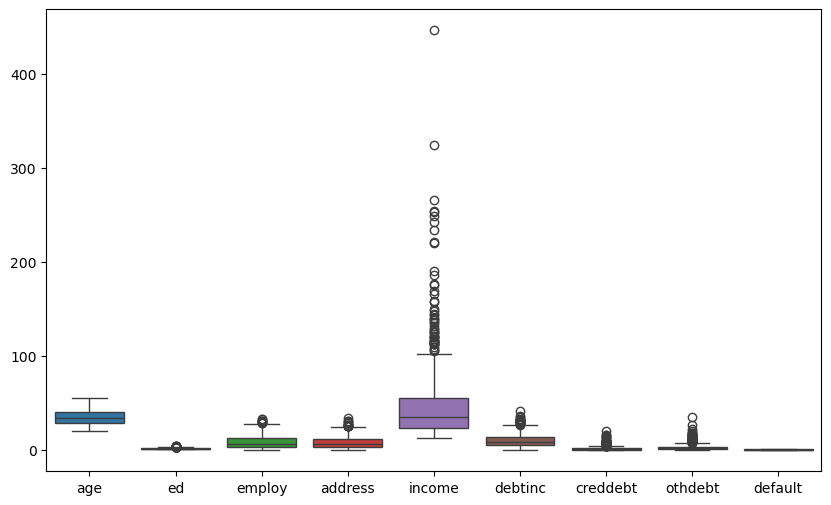

In [137]:
plt.figure(figsize=(10, 6))
sns.boxplot(bankloans.select_dtypes(include='number'))
#data.select_dtypes(include='number').boxplot(vert=False)
plt.show()

#for col in people_with_info.select_dtypes(include='number').columns:
#    sns.boxplot(x=people_with_info[col])
#    plt.show()

#### Missing values imputation for continuous and categorical variable 

In [138]:
def missing_imputation(x, stats='mean'):
     if (x.dtypes == 'int64')|(x.dtypes == 'float64') :
         x=x.fillna(x.mean()) if stats=='mean' else x.fillna(x.median())             
     return x

In [139]:
#if we have both cantinuous and categorical types of variables in dataset

# def missing_imputation(x, stats='mean', variable_type=None):
#     if x.dtypes in ['int64', 'float64']:  # Numeric columns
#         if stats == 'mean':
#             x = x.fillna(x.mean())
#         elif stats == 'median':
#             x = x.fillna(x.median())
#     elif x.dtypes == 'object':  # Categorical columns
#         if variable_type == 'nominal' or stats == 'mode':  # Use mode for nominal
#             x = x.fillna(x.mode()[0])
#         elif variable_type == 'ordinal':  # Handle ordinal (default mode)
#             if stats == 'mode':
#                 x = x.fillna(x.mode()[0])
#             elif stats == 'median':  # Optional for ordinal
#                 x = x.fillna(x.median())
#     return x


###  Segregating the bankloan customers such that we have new and existing customers separate:

In [140]:
# in our dataset there are some customers whose defaulter status is missing so here these customers will be act as new customers and for them we will
# find the defaulter status 

In [141]:
bankloan_existing=bankloans[bankloans.default.notna()]
bankloan_existing

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
...,...,...,...,...,...,...,...,...,...
695,36,2,6,15,27,4.6,0.262062,0.979938,1.0
696,29,2,6,4,21,11.5,0.369495,2.045505,0.0
697,33,1,15,3,32,7.6,0.491264,1.940736,0.0
698,45,1,19,22,77,8.4,2.302608,4.165392,0.0


In [142]:
bankloan_new=bankloans[bankloans.default.isna()]
bankloan_new

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN
...,...,...,...,...,...,...,...,...,...
845,34,1,12,15,32,2.7,0.239328,0.624672,NaN
846,32,2,12,11,116,5.7,4.026708,2.585292,NaN
847,48,1,13,11,38,10.8,0.722304,3.381696,NaN
848,35,2,1,11,24,7.8,0.417456,1.454544,NaN


### Check for balanced dataset

* we must have minimum 20% data in each categorical variable for small dataset it have then no need to data balancing so here we don't need 

In [143]:
bankloan_existing.default.value_counts()   # cardinality of default

default
0.0    517
1.0    183
Name: count, dtype: int64

In [144]:
bankloan_existing.default.value_counts() / bankloan_existing.default.count()  #here we have data more than 20% in both of categories.

default
0.0    0.738571
1.0    0.261429
Name: count, dtype: float64

<Axes: xlabel='default', ylabel='count'>

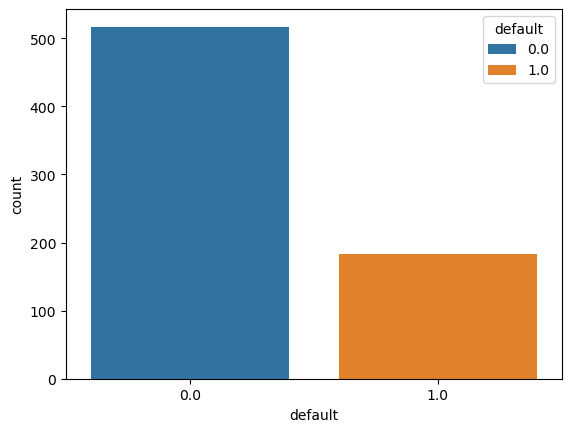

In [145]:
sns.countplot(data=bankloan_existing,x='default',hue='default')

#### Treating Outliers

In [146]:
bankloan_existing=bankloan_existing.apply(lambda x:x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99)))

#### Treating Missings if missing values presend in  data 

In [147]:
bankloan_existing.isna().sum()  

age         0
ed          0
employ      0
address     0
income      0
debtinc     0
creddebt    0
othdebt     0
default     0
dtype: int64

In [148]:
# bankloan_existing.apply(lambda x:x.fillna(missing_imputation))
# bankloan_existing.head(3)

In [149]:
bankloan_existing.apply(continuous_summ)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtypes,float64,int64,float64,float64,float64,float64,float64,float64,float64
caldinality,34,4,29,28,107,221,683,687,2
n_total,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
n_miss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n_outliers,0,43,10,14,40,14,55,48,0
perc_outliers,0.0,6.142857,1.428571,2.0,5.714286,2.0,7.857143,6.857143,0.0
sum,24393.07,1201,5851.07,5771.07,31394.1,7155.507,1049.190134,2119.103279,183.0
mean,34.847243,1.715714,8.358671,8.244386,44.848714,10.222153,1.498843,3.02729,0.261429


### Bivariate Analysis 
    Checking the effect of variable among each others.

In [150]:
#bankloan_existing.corr().to_excel(r"D:\AnalytixLabs Python\Summaries")   #we use it if we have large number of variables in dataset 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'ed'),
  Text(2.5, 0, 'employ'),
  Text(3.5, 0, 'address'),
  Text(4.5, 0, 'income'),
  Text(5.5, 0, 'debtinc'),
  Text(6.5, 0, 'creddebt'),
  Text(7.5, 0, 'othdebt'),
  Text(8.5, 0, 'default')])

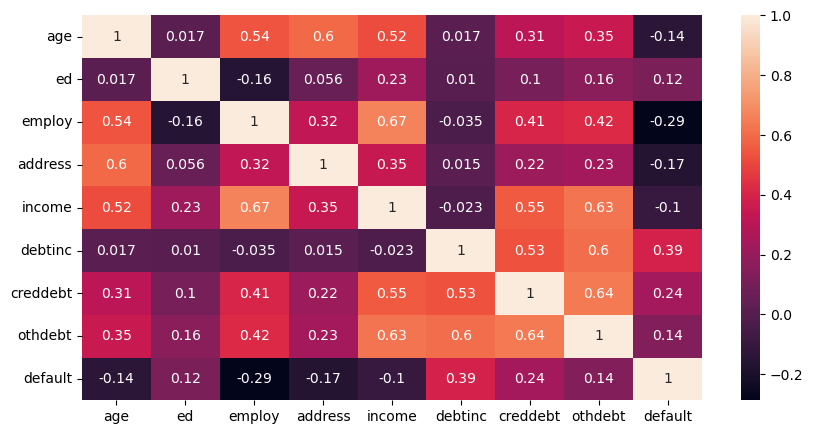

In [151]:
plt.figure(figsize=(10,5))
sns.heatmap(bankloan_existing.corr(),annot=True)
plt.xticks(rotation=0 )

### Building Logistic Regression Model

### Train_test_split

In [152]:
train, test = train_test_split(bankloan_existing, train_size=0.7, test_size=0.3, random_state=1)

In [153]:
train

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
286,29.0,1,11.00,7.0,32.0,6.0,0.927360,0.992640,0.0
146,28.0,4,1.00,3.0,26.0,12.4,0.377208,2.846792,0.0
214,34.0,1,16.00,3.0,75.0,10.4,3.954600,3.845400,0.0
528,51.0,2,27.01,14.0,190.3,7.8,4.272840,15.149160,0.0
165,40.0,2,13.00,11.0,102.0,18.9,6.226794,13.051206,1.0
...,...,...,...,...,...,...,...,...,...
129,41.0,2,19.00,2.0,68.0,5.8,1.506608,2.437392,0.0
144,41.0,1,16.00,17.0,68.0,5.4,0.447984,3.224016,0.0
645,23.0,2,0.00,1.0,42.0,3.9,1.018836,0.619164,1.0
72,47.0,1,26.00,21.0,100.0,12.8,4.582400,8.217600,0.0


In [154]:
test

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
681,21.0,1,4.0,0.0,15.0,9.7,0.200984,1.157016,1.0
626,31.0,1,11.0,12.0,47.0,10.9,2.863757,2.259243,0.0
329,30.0,1,8.0,6.0,23.0,12.0,0.761760,1.998240,0.0
620,25.0,1,1.0,1.0,19.0,6.9,0.190095,1.120905,0.0
399,23.0,1,2.0,2.0,16.0,9.6,0.804864,0.731136,1.0
...,...,...,...,...,...,...,...,...,...
160,21.0,1,4.0,0.0,26.0,8.9,1.420796,0.893204,0.0
442,39.0,1,23.0,1.0,75.0,18.9,3.132675,11.042325,0.0
611,46.0,1,9.0,23.0,31.0,13.8,1.617084,2.660916,0.0
578,28.0,2,3.0,1.0,36.0,8.6,0.383904,2.712096,0.0


* Here we will use stastical models

### Model 0 : Considering all features without any varible reduction 

In [155]:
formula0='default ~ ' + ' + '.join(train.columns.difference(['default']))
formula0

'default ~ address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [156]:
m0 = smf.logit(formula = formula0, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.398129
         Iterations 8


In [157]:
mo_summary = m0.summary2()
print(mo_summary)

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.302     
Date:               2025-06-05 14:03 AIC:              407.3698  
No. Observations:   489              BIC:              445.1010  
Df Model:           8                Log-Likelihood:   -194.68   
Df Residuals:       480              LL-Null:          -279.03   
Converged:          1.0000           LLR p-value:      2.4368e-32
No. Iterations:     8.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.6798    0.7856  -2.1383  0.0325  -3.2194  -0.1401
address       -0.1068    0.0275  -3.8879  0.0001  -0.1607  -0.0530
age            0.0421    0.0206   2.0509  0.0403   0.0019   0.0824
creddebt       0.7383    0.153

* ***In the above output:***

1. *Optimization terminated successfully:*
    
        It means that the algorithm used to fit the logistic regression model has successfully converged to a solution. It found a set of parameters that will minimize the loss function (the difference between predicted and actual values).
    
2. *Current function value: 0.399044:*
    
        - This value represents the final value of the loss function (often the negative log-likelihood in logistic regression). A lower value typically indicates a **better fit** of the model to the data. 
        
        - In this context, 0.399044 suggests the model's fit; you might compare it with other models or baseline values to assess performance.
    
3. *Iterations 8:*
    
        This tells you that the optimization algorithm took 8 iterations to converge to the solution. Fewer iterations can indicate quicker convergence, which may suggest that the model's parameters were relatively straightforward to optimize.

* on the basis of the results of the model 0 summary we can say that it is not good model as it does not gives considerable pseudo r squared, p values and other values.

### Variable Selection:
* Done before train-test split.
* Variable Reduction using Somer's D values:

    - Bi-variate analysis technique to check the predictive power of each independent against dependent
    - cutoff is 0.2 or 20% below which the variable is insignificant

##### Get the Somars'D values for bi-variate analysis:

In [158]:
somersd_score=pd.DataFrame()

for var_name in bankloan_existing.columns.difference(['default']):

    # Build and fit the logistic regression model using the current independent variable as predictor at a time
    LR_mod=smf.logit('default ~ ' + var_name , data=bankloan_existing).fit()

    # Predict the probability of the dependent variable ('default') being 1
    y_pred_prob = LR_mod.predict(bankloan_existing)
    
    # Compute the ROC AUC score to evaluate the model's ability to classify outcomes
    concordance = roc_auc_score(bankloan_existing['default'] , y_pred_prob)

    # Calculate Somers' D statistic based on the ROC AUC score
    somers_d = 2*concordance -1

    # Create a temporary dataframe to store the current variable's result
    temp_data=pd.DataFrame([var_name, concordance, somers_d]).T

    # Append the temporary dataframe to the main results dataframe
    somersd_score= pd.concat([somersd_score, temp_data], axis=0,ignore_index=True)    #to concat the result of different iterations on each variables 

somersd_score.columns = ['variable', 'roc_auc_score', 'somers_d']
somersd_score

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


,variable,roc_auc_score,somers_d
0,address,0.611192,0.222384
1,age,0.603165,0.206329
2,creddebt,0.636189,0.272378
3,debtinc,0.735253,0.470506
4,ed,0.574151,0.148302
5,employ,0.704569,0.409138
6,income,0.600136,0.200273
7,othdebt,0.586903,0.173806


 
smf.logit(formula='default ~ ' + var_name, data=bankloans_existing)
```
### 1. What is Logistic Regression?
Logistic regression is a statistical method used for binary classification problems (dependent variable = 0 or 1). It models the relationship between a binary dependent variable and one or more independent variables using the log-odds of the dependent variable.

The logistic regression formula is:
log-odds (log(p/1-p)) = beta_0 + beta_1 X_1 + beta_2 X_2 + .... + beta_k X_k

where p is the probability of the dependent variable being `1`.

---

### 2. How `smf.logit()` Works
The `logit` function is used to define and fit a logistic regression model/

- formula='default ~ var_name'
  - Specifies the relationship between the dependent variable (`default`) and the independent variable (`var_name`).
  - Follows a **formula syntax** where `Y ~ X1 + X2 + ...` means "Y is modeled as a function of X1, X2, etc."
  - In this case, the dependent variable (`default`) is modeled as a function of a single independent variable (`var_name`).

---

### 3. Steps Involved

1. Model Specification:

   smf.logit(formula='default ~ ' + var_name, data=bankloans_existing)
   ```
   - This creates a logistic regression model where:
     - The dependent variable is `default`.
     - The independent variable is the current `var_name` from the loop.
   - For example, if `var_name = 'age'`, the formula becomes:
     ```
     smf.logit(formula='default ~ age', data=bankloans_existing)
     ```

2. **Model Fitting**:
   The `.fit()` method is applied to the model to estimate the coefficients (parameters \(\beta_0, \beta_1\), etc.) by maximizing the **log-likelihood**.

   ```  

3. **Output**:
   - After fitting, the logistic regression model (`log_mod`) contains:
     - Estimated coefficients (\(\beta_0, \beta_1\)).
     - Statistical summaries, including p-values, standard errors, etc.
     - The model is now ready to predict probabilities or classify outcomes.

---

 

#### Formula for `age`:
```python
#smf.logit(formula='default ~ age', data=bankloans_existing).fit()
```

#### Model Fitting:
This fits a logistic regression model with:
{log-odds(default = 1)} = beta_0 + beta_1 {age}

#### Predictions:
     log_mod.predict(bankloans_existing)
```
to predict the probabilities of `default = 1` for each observation.
---
The `smf.logit()` function allows you to easily specify and fit logistic regression models using a formula-based approach, where the relationship between dependent and independent variables is defined in a compact, readable syntax.(Maximul likelyhood Estimation)

In [159]:
features = list(somersd_score.loc[somersd_score.somers_d>=0.2, 'variable'])
print(features)

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']


#### Model 1 : After variable selection but not multicolinearity check

In [160]:
formula1 = 'default ~ ' + ' + '.join(features)
formula1

'default ~ address + age + creddebt + debtinc + employ + income'

In [161]:
m1 = smf.logit(formula1, data = train).fit()

Optimization terminated successfully.
         Current function value: 0.398998
         Iterations 7


In [162]:
# Model Summary
m1_summary=m1.summary2()
print(m1_summary)

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.301     
Date:               2025-06-05 14:03 AIC:              404.2203  
No. Observations:   489              BIC:              433.5668  
Df Model:           6                Log-Likelihood:   -195.11   
Df Residuals:       482              LL-Null:          -279.03   
Converged:          1.0000           LLR p-value:      1.2972e-33
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.9354    0.6378  -3.0346  0.0024  -3.1854  -0.6854
address       -0.1068    0.0275  -3.8811  0.0001  -0.1607  -0.0529
age            0.0400    0.0204   1.9605  0.0499   0.0000   0.0800
creddebt       0.6866    0.137

### Multicolinearity check
   * using vif()

In [163]:
equation = 'default ~ ' + ' + '.join(features)
equation

'default ~ address + age + creddebt + debtinc + employ + income'

In [164]:
y, x = dmatrices(equation, data = bankloan_existing, return_type = 'dataframe')

In [165]:
vif= pd.DataFrame()
vif['features'] = x.columns
vif['vif_score'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif

,features,vif_score
0,Intercept,28.286222
1,address,1.559236
2,age,2.036933
3,creddebt,2.564921
4,debtinc,1.778339
5,employ,1.997947
6,income,2.601717


* **NOTE:**

    * All variables, except Intercept have VIF < 5. 
    * Thus, no issue of multi-colinearity

### Model 2 : With significant variables after checking p-values from the summary output.

In [166]:
significant_features = ['address', 'creddebt', 'debtinc', 'employ']

In [167]:
formula2 = 'default ~ ' + ' + '.join(significant_features)
m2 = smf.logit(formula2 , data = train).fit()
print(m2.summary2())

Optimization terminated successfully.
         Current function value: 0.403114
         Iterations 7
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: default          Pseudo R-squared: 0.294     
Date:               2025-06-05 14:03 AIC:              404.2456  
No. Observations:   489              BIC:              425.2074  
Df Model:           4                Log-Likelihood:   -197.12   
Df Residuals:       484              LL-Null:          -279.03   
Converged:          1.0000           LLR p-value:      2.2319e-34
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.0376    0.3030  -3.4244  0.0006  -1.6315  -0.4437
address       -0.0810    0.0230  -3.5183  0.0004  -0.1262  -0.

### Predictions on Train and Test

In [168]:
train_predict = m2.predict(train)
test_predict = m2.predict(test)

In [169]:
train_predict       # y_predicted_probabilites for train data

286    0.053533
146    0.460122
214    0.208246
528    0.009536
165    0.700782
         ...   
129    0.020755
144    0.005933
645    0.467250
72     0.012705
235    0.161592
Length: 489, dtype: float64

In [170]:
test_predict     # y_predicted_probabilites for test data

681    0.285495
626    0.164695
329    0.152742
620    0.353536
399    0.431760
         ...   
160    0.445138
442    0.079158
611    0.068545
578    0.317755
103    0.004749
Length: 210, dtype: float64

### ROC_AUC_Score

In [171]:
# Model Accuracies using auc_roc_soore
train_auc = roc_auc_score(train.default, train_predict)
test_auc = roc_auc_score(test.default, test_predict)
print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.8485723031177577
The AUC for the model built on the Test Data is :  0.8576998050682261


#### combine Y_actual and Y_predicted_probabilites

In [172]:
train_pred_prob = pd.DataFrame(train_predict)
train_pf = pd.concat([train.default, train_pred_prob], axis = 1). reset_index(drop = True)
train_pf.columns = ['actual', 'prob']
train_pf

,actual,prob
0,0.0,0.053533
1,0.0,0.460122
2,0.0,0.208246
3,0.0,0.009536
4,1.0,0.700782
...,...,...
484,0.0,0.020755
485,0.0,0.005933
486,1.0,0.467250
487,0.0,0.012705


In [173]:
test_pred_prob = pd.DataFrame(test_predict)
test_pf = pd.concat([test.default, test_pred_prob], axis = 1). reset_index(drop = True)
test_pf.columns = ['actual', 'prob']
test_pf

,actual,prob
0,1.0,0.285495
1,0.0,0.164695
2,0.0,0.152742
3,0.0,0.353536
4,1.0,0.431760
...,...,...
205,0.0,0.445138
206,0.0,0.079158
207,0.0,0.068545
208,0.0,0.317755


#### Get the best cut off using either of the followings:

Senstivity + Specificity	To get the best cutoff

Accuracy

TPR - True Positive Rate (Senstivity) 	



In [174]:
# we dont know the best cutoff; thus will iterate for each probabily value between 0 and 1

# declare an empty dataframe
best_cutoff_df = pd.DataFrame()

# iterate for different probabilities
for iprob in np.arange(0,1.01,0.01) :
    
    # use one proba as cutoff and do the predictions
    y_predicted = pd.Series(np.where(train_pf.prob>=iprob,1,0))
    
    # create a confusion matrix
    cm = confusion_matrix(train_pf.actual,y_predicted)[::-1,::-1]
    
    # confusion matrix is created on y_actual & y_pred
    tp= cm[0,0]
    tn= cm[1,1]
    fp= cm[1,0]
    fn= cm[1,0]
    
    #get the row totals
    row_total = cm.sum(axis=1)
    
    # tpr, fpr, specificity, senstivity + specificity, accuracy
    tpr=tp/row_total[0]
    fpr=fp/row_total[1]
    specificity= 1-fpr
    accuracy = tp+tn/cm.sum()
    sen_spec= tpr+specificity
    
    # save the data in the temporary dataframe
    temp_data =pd.DataFrame([iprob,tp,tn,fp,fn,tpr,fpr,specificity,accuracy,sen_spec]).T

    # save the data in the output dataframe
    best_cutoff_df = pd.concat([best_cutoff_df,temp_data],axis=0,ignore_index=True)
    
# add the variable names
best_cutoff_df.columns = ['proba', 'tp', 'tn', 'fp', 'fn', 'tpr', 'fpr', 'specificity', 
                                  'accuracy', 'sen_spec']
best_cutoff_df   
                            

,proba,tp,tn,fp,fn,tpr,fpr,specificity,accuracy,sen_spec
0,0.00,126.0,0.0,363.0,363.0,1.000000,1.000000,0.000000,126.000000,1.000000
1,0.01,126.0,41.0,322.0,322.0,1.000000,0.887052,0.112948,126.083845,1.112948
2,0.02,126.0,66.0,297.0,297.0,1.000000,0.818182,0.181818,126.134969,1.181818
3,0.03,125.0,89.0,274.0,274.0,0.992063,0.754821,0.245179,125.182004,1.237243
4,0.04,124.0,104.0,259.0,259.0,0.984127,0.713499,0.286501,124.212679,1.270628
...,...,...,...,...,...,...,...,...,...,...
96,0.96,2.0,363.0,0.0,0.0,0.015873,0.000000,1.000000,2.742331,1.015873
97,0.97,0.0,363.0,0.0,0.0,0.000000,0.000000,1.000000,0.742331,1.000000
98,0.98,0.0,363.0,0.0,0.0,0.000000,0.000000,1.000000,0.742331,1.000000
99,0.99,0.0,363.0,0.0,0.0,0.000000,0.000000,1.000000,0.742331,1.000000


##### We will choose the max of (sens + spec):

### Finding Best Cutoff
    (choosen best cutoff based on highest (sensitivity + specificity)

In [175]:
best_cutoff = best_cutoff_df.loc[best_cutoff_df.sen_spec==best_cutoff_df.sen_spec.max(),'proba']
bestcutoff =best_cutoff.iloc[0]
bestcutoff

0.28

In [176]:
train_pf['predicted'] = pd.Series(np.where(train_pf.prob>=bestcutoff, 1, 0))
test_pf['predicted'] = pd.Series(np.where(test_pf.prob>=bestcutoff, 1, 0))

In [177]:
train_pf.head()

,actual,prob,predicted
0,0.0,0.053533,0
1,0.0,0.460122,1
2,0.0,0.208246,0
3,0.0,0.009536,0
4,1.0,0.700782,1


In [178]:
test_pf.head()

,actual,prob,predicted
0,1.0,0.285495,1
1,0.0,0.164695,0
2,0.0,0.152742,0
3,0.0,0.353536,1
4,1.0,0.431760,1


### Accuracy Score

In [179]:
print('The overall accuracy score for the train data is :',accuracy_score(train_pf.actual, train_pf.predicted))
print('The overall accuracy score for the test data is :',accuracy_score(test_pf.actual, test_pf.predicted))

The overall accuracy score for the train data is : 0.7893660531697342
The overall accuracy score for the test data is : 0.7666666666666667


### Confusion matrix on y_actual and y_predicted

In [180]:
confusion_matrix(train_pf.actual, train_pf.predicted)

array([[288,  75],
       [ 28,  98]], dtype=int64)

### Classification Report

In [181]:
print(classification_report(train_pf.actual, train_pf.predicted))

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85       363
         1.0       0.57      0.78      0.66       126

    accuracy                           0.79       489
   macro avg       0.74      0.79      0.75       489
weighted avg       0.82      0.79      0.80       489



In [182]:
# at default cutoff 0.5
y_pred = pd.Series(np.where(train_pf.prob>=0.5,1,0))
print(classification_report(train_pf.actual,y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87       363
         1.0       0.67      0.48      0.56       126

    accuracy                           0.80       489
   macro avg       0.75      0.70      0.71       489
weighted avg       0.79      0.80      0.79       489



### Decile Analysis for validation of model -Business validation

In [108]:
train_pf['Deciles'] = pd.qcut(train_pf.prob, 10 , labels = False)
test_pf['Deciles'] = pd.qcut(test_pf.prob, 10 ,labels = False )

In [109]:
train_pf

,actual,prob,predicted,Deciles
0,0.0,0.053533,0,2
1,0.0,0.460122,1,7
2,0.0,0.208246,0,5
3,0.0,0.009536,0,0
4,1.0,0.700782,1,9
...,...,...,...,...
484,0.0,0.020755,0,1
485,0.0,0.005933,0,0
486,1.0,0.467250,1,8
487,0.0,0.012705,0,1


In [110]:
test_pf

,actual,prob,predicted,Deciles
0,1.0,0.285495,1,6
1,0.0,0.164695,0,4
2,0.0,0.152742,0,4
3,0.0,0.353536,1,7
4,1.0,0.431760,1,7
...,...,...,...,...
205,0.0,0.445138,1,7
206,0.0,0.079158,0,3
207,0.0,0.068545,0,2
208,0.0,0.317755,1,6


In [111]:
train_deciles = train_pf.groupby('Deciles')[['prob','actual']].agg({ 'prob' : ['max', 'min'],
                                                                    'actual' : ['sum', 'count']}).sort_values(by = 'Deciles', ascending = False).reset_index(   )
test_deciles = test_pf.groupby('Deciles')[['prob','actual']].agg({'prob' : ['max', 'min'],
                                                                  'actual' : ['sum', 'count']}).sort_values(by = 'Deciles', ascending = False).reset_index( )

In [112]:
train_deciles

Deciles      prob           actual      
                max       min    sum count
0       9  0.967836  0.676023   39.0    49
1       8  0.675160  0.467250   26.0    49
2       7  0.466431  0.337468   21.0    49
3       6  0.329127  0.239995   14.0    49
4       5  0.239815  0.190572    8.0    48
5       4  0.188976  0.128023    9.0    49
6       3  0.127036  0.067027    4.0    49
7       2  0.065942  0.036831    3.0    49
8       1  0.036818  0.012340    2.0    49
9       0  0.012276  0.000864    0.0    49

In [113]:
test_deciles

Deciles      prob           actual      
                max       min    sum count
0       9  0.985679  0.643839   18.0    21
1       8  0.612833  0.470155   13.0    21
2       7  0.459267  0.353536    6.0    21
3       6  0.347456  0.254467    9.0    21
4       5  0.250986  0.169139    5.0    21
5       4  0.168526  0.105759    1.0    21
6       3  0.103146  0.074453    2.0    21
7       2  0.074050  0.042419    3.0    21
8       1  0.042086  0.015149    0.0    21
9       0  0.013653  0.001642    0.0    21

### Predict the default for new customers

In [117]:
bankloan_new_cust_data = bankloan_new[significant_features]
bankloan_new_cust_data.head()

,address,creddebt,debtinc,employ
700,13,0.544128,10.9,16
701,27,1.316574,12.9,6
702,9,4.880700,17.0,9
703,7,0.046000,2.0,5
704,0,0.866736,7.8,4


In [125]:
import warnings
warnings.filterwarnings('ignore')

In [184]:
bankloan_new['prob'] = m2.predict(bankloan_new_cust_data)   
bankloan_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,0.014081
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,0.072272
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,0.703463
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,0.077132
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,0.339222


In [185]:
bankloan_new['default'] = bankloan_new['prob'].apply(lambda x: 1 if x> 0.5 else 0)
bankloan_new.reset_index(drop = True).head()
 

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
0,36,1,16,13,32,10.9,0.544128,2.943872,0,0.014081
1,50,1,6,27,21,12.9,1.316574,1.392426,0,0.072272
2,40,1,9,9,33,17.0,4.880700,0.729300,1,0.703463
3,31,1,5,7,23,2.0,0.046000,0.414000,0,0.077132
4,29,1,4,0,24,7.8,0.866736,1.005264,0,0.339222


In [186]:
bankloan_new['default'] = bankloan_new['prob'].apply(lambda x: 1 if x> 0.5 else 0)
bankloan_new.reset_index(drop = True)
bankloan_new.default.value_counts()  

default
0    127
1     23
Name: count, dtype: int64

In [188]:
bankloan_new.drop(columns=['prob'],inplace=True)

### Conclusion: We will reject the loan approval for 23 customers as there default status = 1

In [195]:
defaulter_customers = bankloan_new[bankloan_new['default']==1]
defaulter_customers.head(23)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
702,40,1,9,9,33,17.0,4.880700,0.729300,1
707,50,1,30,8,150,32.5,13.552500,35.197500,1
716,26,4,1,5,92,13.0,6.506240,5.453760,1
732,30,1,1,1,27,12.3,1.275264,2.045736,1
740,26,3,3,1,40,10.8,1.896480,2.423520,1
745,37,4,2,1,29,15.4,2.782318,1.683682,1
756,21,2,1,0,17,10.5,0.555135,1.229865,1
763,21,3,0,1,41,19.5,2.366520,5.628480,1
770,22,4,0,1,25,12.2,1.491450,1.558550,1
773,29,2,9,8,30,21.7,3.645600,2.864400,1


In [196]:
non_defaulter_customers = bankloan_new[bankloan_new['default']==0]
non_defaulter_customers.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,0
701,50,1,6,27,21,12.9,1.316574,1.392426,0
703,31,1,5,7,23,2.0,0.046000,0.414000,0
704,29,1,4,0,24,7.8,0.866736,1.005264,0
705,25,2,1,3,14,9.9,0.232848,1.153152,0
